## __BAX-452 Assignment 4: Understanding the Impact of Ozempic on Obese and Hypertensive Patients__  

#### 001 - Yumi Jin   

### __1. Exploratory Data Analysis (EDA):__  

Conduct a thorough exploration of the provided datasets. This includes understanding the structure, identifying missing values, and summarizing key statistics.  
Generate visualizations to understand the distribution of important variables, relationships between different variables, and any other patterns or anomalies in the data such as peculiar patterns or outliers. (20 pts)

In [463]:
# load the packages
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
from sklearn.linear_model import LassoCV
from statsmodels.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, r2_score

In [198]:
# read in the data
medical = pd.read_csv('/Users/yumi/ucdavis/Winter Quarter/BAX-452/Assignments/HW4/longyear-obese-hypertensive-40-57-medical-SMALL-sample.csv')
scripts = pd.read_csv('/Users/yumi/ucdavis/Winter Quarter/BAX-452/Assignments/HW4/longyear-obese-hypertensive-40-75-scripts-SMALL-sample.csv', low_memory=False)
# use 'low_memory = False' to load the entire file into memory to better determine the correct data types for each column

#### __1.1 Explore Medical dataset__

I notice that there are many completely identical rows, so we drop them at the very beginning.

In [199]:
medical = medical.drop_duplicates()

In [200]:
# display the first 5 observations
medical.head(5)

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
0,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
2,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3074F,NaN,1.0,0.00,0.00,46.57
3,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3078F,NaN,1.0,0.00,0.00,56.38
4,00006d564a4718c744f1bbf1b6c5f8c3,42ba4419d9ad7c9293d76686fb608f10,9e4534892128401c693a6ab2ea758cd6a0a6484972168b...,da5cef18317c14180ed561a84001d8a033d724d541a2c0...,2023-08-11,CA,900.0,55.0,F,Independent Laboratory,...,NaN,NaN,NaN,1.0,80053,NaN,1.0,88.07,88.07,15.16
5,00006d564a4718c744f1bbf1b6c5f8c3,cad5e8635fd011bfec2b65d161b15254,3b0f0f71ac05c34ab9307c4853f1af59420c07b522cdf2...,eafff3ebf33ebe534edc66e761d9b52d1381653d9d0d57...,2019-11-01,CA,900.0,50.0,F,Office,...,M4317,N200,NaN,1.0,72072,NaN,1.0,107.00,107.00,72.42


In [201]:
# understand data type
medical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563202 entries, 0 to 623524
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         563202 non-null  object 
 1   episode_id         563202 non-null  object 
 2   visit_id           561496 non-null  object 
 3   encounter_id       563202 non-null  object 
 4   claim_date         563202 non-null  object 
 5   patient_state      563202 non-null  object 
 6   patient_short_zip  563189 non-null  float64
 7   patient_age        557352 non-null  float64
 8   patient_gender     563073 non-null  object 
 9   place_of_service   439462 non-null  object 
 10  visit_type         543032 non-null  object 
 11  payor              549688 non-null  object 
 12  payor_channel      528756 non-null  object 
 13  ref_npi            269303 non-null  float64
 14  hcp_npi            397159 non-null  float64
 15  hcp_taxonomy       391502 non-null  object 
 16  hcp_spe

The dataset appears to be quite comprehensive, with detailed information on medical claims. I will proceed by checking for missing values and summarizing key statistics to better understand the data's distribution.

In [202]:
# check for null values proportion
medical.isnull().sum()/len(medical)

journey_id           0.000000
episode_id           0.000000
visit_id             0.003029
encounter_id         0.000000
claim_date           0.000000
patient_state        0.000000
patient_short_zip    0.000023
patient_age          0.010387
patient_gender       0.000229
place_of_service     0.219708
visit_type           0.035813
payor                0.023995
payor_channel        0.061161
ref_npi              0.521836
hcp_npi              0.294820
hcp_taxonomy         0.304864
hcp_specialty        0.304828
hco_npi              0.009370
hcp_npi_list         0.294820
hco_npi_list         0.009370
diag_list            0.001495
diag_1               0.001495
diag_2               0.260324
diag_3               0.412351
diag_4               0.519201
diag_5               0.668595
rev_center_code      0.818300
rev_center_units     0.003182
proc_code            0.038535
proc_modifier        0.736235
proc_units           0.003493
line_charge          0.000000
claim_charge         0.000000
smart_allo

The dataset has a significant amount of missing values in several columns, particularly in diagnostic codes (diag_2 to diag_5), revenue center code, and procedure modifier, among others. 

In [203]:
# display the summary of the data
medical.describe()

,patient_short_zip,patient_age,ref_npi,hcp_npi,hco_npi,rev_center_code,rev_center_units,proc_units,line_charge,claim_charge,smart_allowed
count,563189.000000,557352.000000,2.693030e+05,3.971590e+05,5.579250e+05,102334.000000,561410.000000,561235.000000,563202.000000,563202.000000,563202.000000
mean,907.626690,59.519343,1.502519e+09,1.508670e+09,1.485017e+09,454.976850,1.246704,4.324408,486.533723,486.533723,190.976152
std,39.246124,9.937488,2.871455e+08,2.827066e+08,2.858330e+08,447.176076,2.501896,56.419328,3669.283114,3669.283114,514.356325
min,74.000000,30.000000,1.003001e+09,1.003001e+09,1.003006e+09,1.000000,-14.000000,0.000000,0.000000,0.000000,0.000000
25%,900.000000,55.000000,1.255466e+09,1.265637e+09,1.245371e+09,301.000000,1.000000,1.000000,10.000000,10.000000,18.320000
50%,911.000000,60.000000,1.508994e+09,1.528015e+09,1.467598e+09,320.000000,1.000000,1.000000,69.000000,69.000000,75.230000
75%,922.000000,65.000000,1.740389e+09,1.740389e+09,1.720295e+09,521.000000,1.000000,1.000000,200.000000,200.000000,183.150000
max,999.000000,80.000000,1.992999e+09,1.993000e+09,1.992995e+09,3103.000000,730.000000,12473.000000,778750.000000,778750.000000,45035.960000


__patient_age:__ The age of patients ranges from 30 to 80 years old, with a mean age of approximately 59.52 years. This suggests the dataset primarily involves older adults.  
__line_charge and claim_charge:__ These fields have the same summary statistics, indicating each row might represent a single charge line of a claim. We should drop one of them when building the model later.

In [204]:
# unique values and frequency counts for patient_short_zip
zip_counts = medical['patient_short_zip'].value_counts()
print(zip_counts.head())  # Display the top 5 ZIP codes

# unique values and frequency counts for visit_type
visit_type_counts = medical['visit_type'].value_counts()
print(visit_type_counts.head())  # Display the top 5 visit types

patient_short_zip
900.0    163704
922.0    150320
908.0     49781
921.0     46435
910.0     43613
Name: count, dtype: int64
visit_type
outpatient visit                  331733
laboratory visit                  125155
inpatient visit                    41014
home visit                         21072
non-hospital institution visit     11960
Name: count, dtype: int64


In [205]:
# combine diag_1, diag_2, diag_3, diag_4, diag_5 columns and identify most common diagnosis
# select 'diag_' columns
diag_columns = [col for col in medical.columns if col.startswith('diag_')]
df_diag = medical[diag_columns]

# combine values 
combined_list = df_diag.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# process first three digits (same as before)
first_three_counts = {}
for diag_code in combined_list:
    first_three = diag_code[:3]
    first_three_counts[first_three] = first_three_counts.get(first_three, 0) + 1  

# sort the dictionary items by count in descending order
sorted_counts = sorted(first_three_counts.items(), key = operator.itemgetter(1), reverse = True)

# print the top 8 diagnosis to screen
sorted_counts[:8]

[('E11', 211459),
 ('I10', 182243),
 ('E78', 103400),
 ('Z00', 86398),
 ('E66', 64255),
 ('Z68', 49646),
 ('M25', 46770),
 ('M54', 45206)]

#### __Top 8 Diagnosis:__  

 -- E11  Type 2 diabetes mellitus   

 -- __I10  Essential (primary) hypertension__  

 -- E78  Disorders of lipoprotein metabolism and other lipidemias  

 -- Z00  Encounter for general examination without complaint, suspected or reported diagnosis 

 -- __E66  Overweight and obesity__  

 -- Z68  Body mass index  

 -- M25  Other joint disorder, not elsewhere classified  

 -- M54  Dorsalgi  

In [206]:
# filter to ozempic users only
ozempic = medical[(medical['proc_code'] == "J3490") |
                  (medical['proc_code'] == "C9399") ]

I did some research and found that the CPT code for Ozempic can be represented as C9399 / J3490.

In [207]:
# do the same thing for ozempic users only
# select 'diag_' columns
diag_columns = [col for col in ozempic.columns if col.startswith('diag_')]
df_diag = ozempic[diag_columns]

# combine values 
combined_list = df_diag.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# process first three digits (same as before)
first_three_counts = {}
for diag_code in combined_list:
    first_three = diag_code[:3]
    first_three_counts[first_three] = first_three_counts.get(first_three, 0) + 1  

# sort the dictionary items by count in descending order
sorted_counts = sorted(first_three_counts.items(), key = operator.itemgetter(1), reverse = True)

# print the top 10 diagnosis to screen
sorted_counts[:8]

[('I10', 230),
 ('E11', 220),
 ('E78', 127),
 ('N18', 95),
 ('I25', 83),
 ('M54', 71),
 ('E66', 69),
 ('Z79', 67)]

#### __Top 8 Diagnosis for OZP users only:__  

 -- __I10  Essential (primary) hypertension__  
 
 -- E11  Type 2 diabetes mellitus   

 -- E78  Disorders of lipoprotein metabolism and other lipidemias  

 -- N18  Chronic kidney disease (CKD)   
 
 -- I25  Chronic ischemic heart disease  
 
 -- M54  Dorsalgi   

 -- __E66  Overweight and obesity__   
 
 -- Z79  Long term (current) drug therapy  

In [208]:
# extract obese patients df
obesity = medical[medical['diag_1'].str.startswith("E66")|
                  medical['diag_2'].str.startswith("E66")|
                  medical['diag_3'].str.startswith("E66")|
                  medical['diag_4'].str.startswith("E66")|
                  medical['diag_5'].str.startswith("E66")]

In [209]:
obesity['diag'] = "Obesity"
obesity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58111 entries, 22 to 623506
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   journey_id         58111 non-null  object 
 1   episode_id         58111 non-null  object 
 2   visit_id           57990 non-null  object 
 3   encounter_id       58111 non-null  object 
 4   claim_date         58111 non-null  object 
 5   patient_state      58111 non-null  object 
 6   patient_short_zip  58103 non-null  float64
 7   patient_age        57397 non-null  float64
 8   patient_gender     58109 non-null  object 
 9   place_of_service   46423 non-null  object 
 10  visit_type         55230 non-null  object 
 11  payor              55478 non-null  object 
 12  payor_channel      53637 non-null  object 
 13  ref_npi            22423 non-null  float64
 14  hcp_npi            46448 non-null  float64
 15  hcp_taxonomy       45944 non-null  object 
 16  hcp_specialty      45944 

/var/folders/4l/3c780bbd2zn4vfg_zj076cb40000gp/T/ipykernel_28421/106941092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obesity['diag'] = "Obesity"


In [210]:
patients_gender_cnt = obesity.groupby(['diag', 'patient_gender'])['journey_id'].nunique().reset_index(name = 'count')
total_cnt = patients_gender_cnt.groupby('diag')['count'].transform('sum')
patients_gender_cnt['gender_ratio'] = patients_gender_cnt['count']/total_cnt
patients_gender_cnt

,diag,patient_gender,count,gender_ratio
0,Obesity,F,6422,0.587235
1,Obesity,M,4514,0.412765


In [211]:
# extract hypertensive patients df
hypertensive = medical[medical['diag_1'].str.startswith("I10")|
                       medical['diag_2'].str.startswith("I10")|
                       medical['diag_3'].str.startswith("I10")|
                       medical['diag_4'].str.startswith("I10")|
                       medical['diag_5'].str.startswith("I10")]

In [212]:
hypertensive['diag'] = "Hypertensive"
hypertensive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140527 entries, 6 to 623524
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         140527 non-null  object 
 1   episode_id         140527 non-null  object 
 2   visit_id           140342 non-null  object 
 3   encounter_id       140527 non-null  object 
 4   claim_date         140527 non-null  object 
 5   patient_state      140527 non-null  object 
 6   patient_short_zip  140527 non-null  float64
 7   patient_age        139340 non-null  float64
 8   patient_gender     140508 non-null  object 
 9   place_of_service   107492 non-null  object 
 10  visit_type         135896 non-null  object 
 11  payor              135137 non-null  object 
 12  payor_channel      130015 non-null  object 
 13  ref_npi            61027 non-null   float64
 14  hcp_npi            102371 non-null  float64
 15  hcp_taxonomy       101405 non-null  object 
 16  hcp_spe

/var/folders/4l/3c780bbd2zn4vfg_zj076cb40000gp/T/ipykernel_28421/405748614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypertensive['diag'] = "Hypertensive"


In [213]:
patients_gender_cnt = hypertensive.groupby(['diag', 'patient_gender'])['journey_id'].nunique().reset_index(name = 'count')
total_cnt = patients_gender_cnt.groupby('diag')['count'].transform('sum')
patients_gender_cnt['gender_ratio'] = patients_gender_cnt['count']/total_cnt
patients_gender_cnt

,diag,patient_gender,count,gender_ratio
0,Hypertensive,F,10226,0.567386
1,Hypertensive,M,7797,0.432614


#### __1.2 Create Visualizations to understand Medical dataset better__

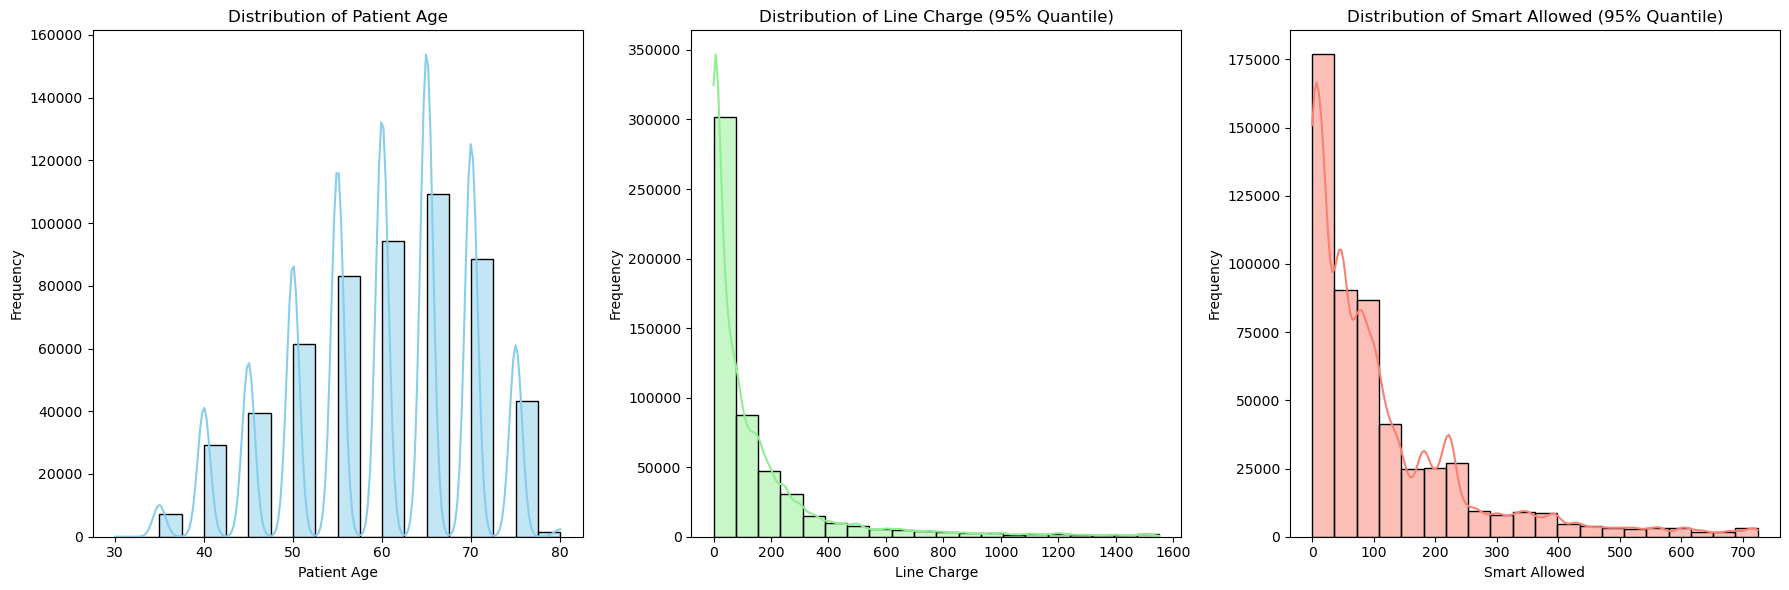

In [214]:
# explore numerical data distribution 
# adjust figure size for better visibility
plt.figure(figsize=(18, 6))

# distribution of patient_age
plt.subplot(1, 3, 1)
sns.histplot(medical['patient_age'].dropna(), bins = 20, kde = True, color = 'skyblue')
plt.title('Distribution of Patient Age')
plt.xlabel('Patient Age')
plt.ylabel('Frequency')

# Distribution of line_charge (excluding extreme outliers)
plt.subplot(1, 3, 2)
sns.histplot(medical[medical['line_charge'] <= medical['line_charge'].quantile(0.95)]['line_charge'], bins = 20, kde = True, color = 'lightgreen')
plt.title('Distribution of Line Charge (95% Quantile)')
plt.xlabel('Line Charge')
plt.ylabel('Frequency')

# Distribution of smart_allowed (excluding extreme outliers)
plt.subplot(1, 3, 3)
sns.histplot(medical[medical['smart_allowed'] <= medical['smart_allowed'].quantile(0.95)]['smart_allowed'], bins = 20, kde = True, color = 'salmon')
plt.title('Distribution of Smart Allowed (95% Quantile)')
plt.xlabel('Smart Allowed')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

__Insights:__ The age of patients ranges from 30 to 80 years old, with a mean around 60.   
The frequency of line charge and smart allowed shows a decreasing trend overall.

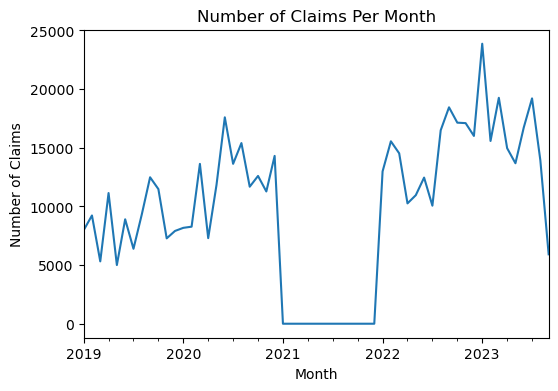

In [215]:
# ensure claim_date is in datetime format
medical['claim_date'] = pd.to_datetime(medical['claim_date'])

# count the number of claims per month
claims_per_month = medical.resample('M', on = 'claim_date').size()

# plot the number of claims per month
claims_per_month.plot(kind = 'line', figsize = (6, 4), title = 'Number of Claims Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Claims')
plt.show()

__Insights:__ We don't have Claims data in 2021.

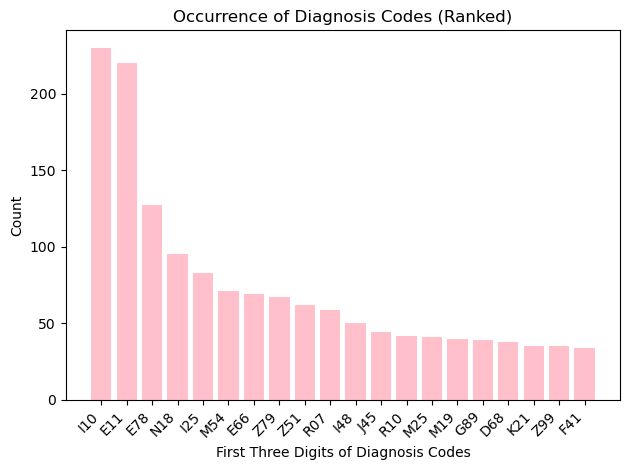

In [216]:
# Extract labels and values
labels = [item[0] for item in sorted_counts[:20]]
values = [item[1] for item in sorted_counts[:20]]

# Create the bar chart
plt.bar(labels, values, color = 'pink')

# Labels and title 
plt.xlabel("First Three Digits of Diagnosis Codes")
plt.ylabel("Count")
plt.title("Occurrence of Diagnosis Codes (Ranked)")

# Optional: Rotate x labels if they are long or overlapping
if len(labels) > 5:  
    plt.xticks(rotation=45, ha='right')  

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

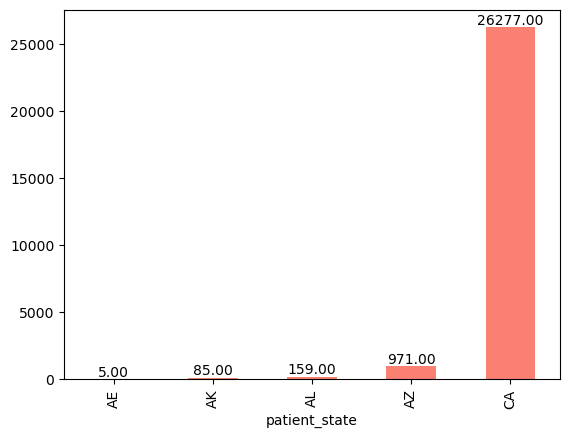

In [217]:
# Check the number of patients' states
patient_state_cnt = medical.groupby('patient_state')['journey_id'].nunique()

# plot a bar plot
patient_state_cnt.plot.bar(color = 'salmon')
for i, v in enumerate(patient_state_cnt):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

__Insights:__ Most patients located in California.

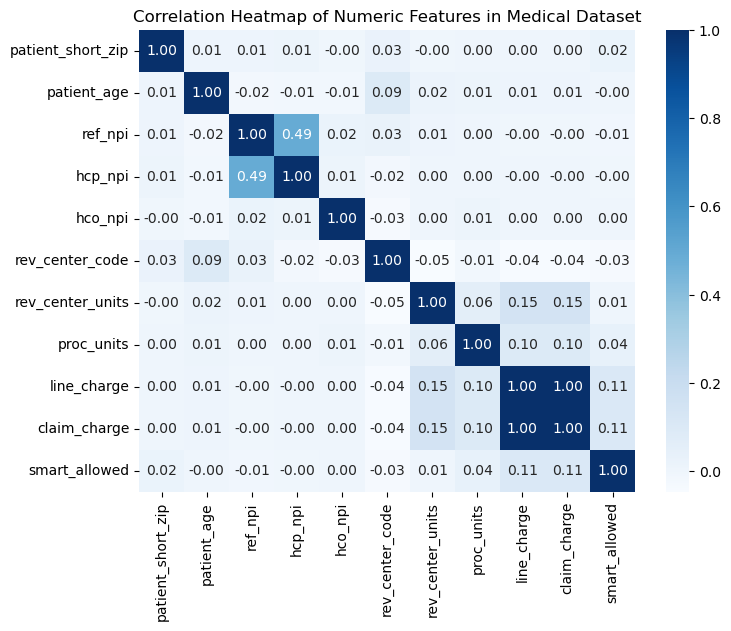

In [218]:
# create heatmap for correlations between all variables 
# select only numeric columns for the correlation matrix
numeric_data = medical.select_dtypes(include=[float, int])

# calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# create a heatmap to visualize the correlations
plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = 'Blues')
plt.title("Correlation Heatmap of Numeric Features in Medical Dataset")
plt.show()

__Insights:__ line_charge and claim_charge are identical things with a correlation of 1.00. We should drop one of them when building the model later.

#### __1.3 Explore Scripts dataset__

In [219]:
# drop identical rows
scripts = scripts.drop_duplicates()

In [220]:
# display the first 5 observations
scripts.head(5)

,journey_id,cohort_id,claim_id,patient_gender,patient_state,patient_zip,patient_dob,pharmacy_npi,pharmacist_npi,prescriber_npi,...,bin,plan_pay,reject_code_1,reject_code_3,reject_code_4,reject_code_5,ndc,active,start_date,end_date
0,00006390c96ebfffed580074c35a16a7,16,60618bd8d37311da702bf9349e76f8c26d515c082e136f...,M,CA,922.0,1961-01-01,1.215361e+09,NaN,1750479168,...,22659.0,NaN,NaN,NaN,NaN,NaN,47335067381,True,190001,NaN
1,00006390c96ebfffed580074c35a16a7,16,dbeb47defd161331e43f4e359e8d43e4ef7546ff58359b...,M,CA,922.0,1961-01-01,1.215361e+09,NaN,1750479168,...,22659.0,NaN,NaN,NaN,NaN,NaN,47335067381,True,190001,NaN
2,00006390c96ebfffed580074c35a16a7,16,02927d081fad10afffcba79bad27f94ff52c98e968aaec...,M,CA,922.0,1961-01-01,1.215361e+09,NaN,1750479168,...,22659.0,NaN,NaN,NaN,NaN,NaN,47335067381,True,190001,NaN
3,00006390c96ebfffed580074c35a16a7,16,a412c986e2503a5140ed1482e88b5ec50feeedaf2d89ec...,M,CA,922.0,1961-01-01,1.215361e+09,NaN,1750479168,...,22659.0,NaN,NaN,NaN,NaN,NaN,47335067381,True,190001,NaN
4,00006390c96ebfffed580074c35a16a7,16,b65634edd78998753fe9606b142b2fff7765d6c576973c...,M,CA,922.0,1961-01-01,1.215361e+09,NaN,1750479168,...,22659.0,NaN,NaN,NaN,NaN,NaN,65862059805,True,190001,NaN


In [221]:
# check for null values 
scripts.isnull().sum()/len(scripts)

journey_id                       0.000000
cohort_id                        0.000000
claim_id                         0.000000
patient_gender                   0.000000
patient_state                    0.000000
patient_zip                      0.000137
patient_dob                      0.000004
pharmacy_npi                     0.061188
pharmacist_npi                   0.975847
prescriber_npi                   0.003882
primary_care_npi                 0.996015
group_id                         0.694940
date_of_service                  0.000000
date_authorized                  0.123067
transaction_type                 0.000000
date_prescription_written        0.000000
ndc11                            0.000000
ndc11_original                   0.894682
number_of_refills_authorized     0.050486
diagnosis_code                   0.804715
diagnosis_code_type              0.875044
quantity_prescribed_original     0.640563
quantity_dispensed               0.000008
place_of_service                 0

In [222]:
# display the summary of the data
scripts.describe()

,cohort_id,patient_zip,pharmacy_npi,pharmacist_npi,ndc11,ndc11_original,number_of_refills_authorized,diagnosis_code_type,quantity_prescribed_original,quantity_dispensed,...,coupon_type,coupon_value_amount,pharmacy_submitted_cost,patient_pay,copay_coinsurance,bin,plan_pay,ndc,start_date,end_date
count,893390.000000,893268.000000,8.387250e+05,2.157800e+04,8.933900e+05,9.409000e+04,848286.000000,111634.000000,321117.000000,8.933830e+05,...,2030.0,5.0,7.838500e+05,601083.000000,410861.000000,785009.000000,491141.000000,8.933900e+05,893390.000000,32382.000000
mean,16.065885,886.775554,1.505579e+09,1.475807e+09,3.913838e+10,1.316275e+10,2.497853,9.999113,10.989208,7.150411e+01,...,88.0,99.0,4.547539e+02,10.878673,7.071637,121890.696186,167.365646,3.913838e+10,190740.306160,201719.180749
std,0.248081,121.688769,2.862561e+08,2.925536e+08,2.808682e+10,2.444945e+10,6.865188,0.029767,84.448469,3.591752e+03,...,0.0,0.0,4.809737e+04,96.613683,59.729186,230754.889077,802.591465,2.808682e+10,2829.338106,400.838036
min,16.000000,100.000000,1.003010e+09,1.003455e+09,2.143301e+06,0.000000e+00,-1.000000,9.000000,0.000000,0.000000e+00,...,88.0,99.0,-7.370000e+00,-189.700000,-3198.400000,0.000000,-1458.620000,2.143301e+06,190001.000000,201001.000000
25%,16.000000,900.000000,1.255441e+09,1.154909e+09,9.046999e+08,0.000000e+00,0.000000,10.000000,0.000000,3.000000e+01,...,88.0,99.0,2.796000e+01,0.000000,0.000000,4336.000000,2.290000,9.046999e+08,190001.000000,201411.000000
50%,16.000000,913.000000,1.497865e+09,1.457999e+09,4.948305e+10,0.000000e+00,1.000000,10.000000,0.000000,3.000000e+01,...,88.0,99.0,9.520000e+01,0.000000,1.350000,17010.000000,13.580000,4.948305e+10,190001.000000,201802.000000
75%,16.000000,922.000000,1.740323e+09,1.689011e+09,6.586206e+10,9.047705e+08,3.000000,10.000000,0.000000,9.000000e+01,...,88.0,99.0,3.220000e+02,4.000000,4.150000,22659.000000,36.290000,6.586206e+10,190001.000000,201907.000000
max,17.000000,992.000000,6.167056e+09,1.992978e+09,9.920701e+10,9.920705e+10,99.000000,10.000000,10000.000000,3.390291e+06,...,88.0,99.0,4.252220e+07,25598.020000,6923.160000,900020.000000,50307.120000,9.920701e+10,202308.000000,202307.000000


---

### __2. Data Preprocessing and Merging:__ 
Prepare the datasets for analysis by handling missing data, encoding categorical variables, and any other necessary preprocessing steps.  
Merge the datasets appropriately, ensuring a coherent structure for further analysis.(15 pts)

In [234]:
# dropping columns that are not that useful or having to much null values
df = medical.drop(['episode_id', 'visit_id', 'encounter_id', 'place_of_service', 'payor',
                   'ref_npi', 'hcp_npi', 'hcp_taxonomy', 'hcp_specialty', 'hcp_npi_list',
                   'hco_npi_list', 'diag_list', 'rev_center_code', 'proc_modifier', 
                   'line_charge'], axis=1)

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563202 entries, 0 to 623524
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   journey_id         563202 non-null  object        
 1   claim_date         563202 non-null  datetime64[ns]
 2   patient_state      563202 non-null  object        
 3   patient_short_zip  563189 non-null  float64       
 4   patient_age        557352 non-null  float64       
 5   patient_gender     563073 non-null  object        
 6   visit_type         543032 non-null  object        
 7   payor_channel      528756 non-null  object        
 8   hco_npi            557925 non-null  float64       
 9   diag_1             562360 non-null  object        
 10  diag_2             416587 non-null  object        
 11  diag_3             330965 non-null  object        
 12  diag_4             270787 non-null  object        
 13  diag_5             186648 non-null  object       

I dropped columns that seems not that helpful, such as 'episode_id' and 'encounter_id'.  
I also dropped columns that are highly correlated with others, such as 'line_charge' (identical with claim_charge) and columns that having too much null values, such as 'ref_npi' and 'hcp_taxonomy'.

In [237]:
df.isnull().sum() / len(df)

journey_id           0.000000
claim_date           0.000000
patient_state        0.000000
patient_short_zip    0.000023
patient_age          0.010387
patient_gender       0.000229
visit_type           0.035813
payor_channel        0.061161
hco_npi              0.009370
diag_1               0.001495
diag_2               0.260324
diag_3               0.412351
diag_4               0.519201
diag_5               0.668595
rev_center_units     0.003182
proc_code            0.038535
proc_units           0.003493
claim_charge         0.000000
smart_allowed        0.000000
dtype: float64

In [238]:
# impute missing values
imputer_mean = SimpleImputer(strategy='mean')

# columns to impute with mean
mean_cols = ['patient_age', 'hco_npi', 'rev_center_units', 'proc_units']

# applying imputation
df[mean_cols] = imputer_mean.fit_transform(df[mean_cols])

# dropping missing rows
df = df.dropna(subset = ['proc_code', 'patient_short_zip', 'patient_gender', 
                         'visit_type', 'payor_channel'])

In [239]:
df.isnull().sum()

journey_id                0
claim_date                0
patient_state             0
patient_short_zip         0
patient_age               0
patient_gender            0
visit_type                0
payor_channel             0
hco_npi                   0
diag_1                  591
diag_2               132600
diag_3               211367
diag_4               266292
diag_5               342053
rev_center_units          0
proc_code                 0
proc_units                0
claim_charge              0
smart_allowed             0
dtype: int64

I impute missing values with mean for some numerical columns which have a small proportion of missing values, and also drop some rows. 

In [240]:
# subset all patients diagnosed as obese or hypertension 
sub_df = df[df['diag_1'].str.startswith("E66")|
            df['diag_2'].str.startswith("E66")|
            df['diag_3'].str.startswith("E66")|
            df['diag_4'].str.startswith("E66")|
            df['diag_1'].str.startswith("I10")|
            df['diag_2'].str.startswith("I10")|
            df['diag_3'].str.startswith("I10")|
            df['diag_4'].str.startswith("I10")|
            df['diag_5'].str.startswith("I10")]

In [241]:
# subset patients 40-75 for desired age range
sub_df = sub_df[(sub_df['patient_age'] >= 40) & (sub_df['patient_age'] <= 75)]

In [242]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139722 entries, 6 to 623524
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   journey_id         139722 non-null  object        
 1   claim_date         139722 non-null  datetime64[ns]
 2   patient_state      139722 non-null  object        
 3   patient_short_zip  139722 non-null  float64       
 4   patient_age        139722 non-null  float64       
 5   patient_gender     139722 non-null  object        
 6   visit_type         139722 non-null  object        
 7   payor_channel      139722 non-null  object        
 8   hco_npi            139722 non-null  float64       
 9   diag_1             139722 non-null  object        
 10  diag_2             133538 non-null  object        
 11  diag_3             123986 non-null  object        
 12  diag_4             109649 non-null  object        
 13  diag_5             78365 non-null   object       

Subset the dataset to the target we are going to analysis.

In [243]:
sub_df.dtypes

journey_id                   object
claim_date           datetime64[ns]
patient_state                object
patient_short_zip           float64
patient_age                 float64
patient_gender               object
visit_type                   object
payor_channel                object
hco_npi                     float64
diag_1                       object
diag_2                       object
diag_3                       object
diag_4                       object
diag_5                       object
rev_center_units            float64
proc_code                    object
proc_units                  float64
claim_charge                float64
smart_allowed               float64
dtype: object

In [244]:
# encode categorical variables
sub_df = pd.get_dummies(sub_df, columns = ['patient_state',
                                           'patient_short_zip',
                                           'patient_gender', 
                                           'visit_type',
                                           'payor_channel'])
# convert bool columns to int64
sub_df = sub_df.astype({col: 'int64' for col in sub_df.columns if sub_df[col].dtype == 'bool'})

# add dummy variable for patient who took ozempic
sub_df['Ozempic'] = sub_df['proc_code'].isin(['J3490', 'C9399']).astype(int)

# drop proc_code because added ozempic dummy 
sub_df.drop(columns = ['proc_code'], inplace = True)

Transforming categorical variables for further analysis.

In [245]:
sub_df['Ozempic'].value_counts()

Ozempic
0    139492
1       230
Name: count, dtype: int64

251 patients diagnosed as either obese or hypertensive take ozempic.    

Now, we need to determine the treatment effect of taking ozempic ---- At 5 diagnoses, if the diagnostic code changes from E66 or I10 (the last not NAN diagnostic is not E66 or I10), we will use the diagnostic code to classify the patient into the success category.

In [246]:
# extract first 3 characters of diagnosis
sub_df['diag_1'] = sub_df['diag_1'].astype(str).str[:3]
sub_df['diag_2'] = sub_df['diag_2'].astype(str).str[:3]
sub_df['diag_3'] = sub_df['diag_3'].astype(str).str[:3]
sub_df['diag_4'] = sub_df['diag_4'].astype(str).str[:3]
sub_df['diag_5'] = sub_df['diag_5'].astype(str).str[:3]

In [247]:
sub_df.head()

,journey_id,claim_date,patient_age,hco_npi,diag_1,diag_2,diag_3,diag_4,diag_5,rev_center_units,...,visit_type_pharmacy visit,payor_channel_commercial,payor_channel_managed medicaid,payor_channel_medicaid,payor_channel_medicare,payor_channel_medicare advantage,payor_channel_tricare,payor_channel_veterans affairs,payor_channel_workers comp,Ozempic
6,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-16,50.0,1.912963e+09,R94,E03,I10,Z68,nan,1.0,...,0,1,0,0,0,0,0,0,0,0
10,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-16,50.0,1.912963e+09,R94,E03,I10,Z68,nan,1.0,...,0,1,0,0,0,0,0,0,0,0
13,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-16,50.0,1.912963e+09,R94,E03,I10,Z68,nan,1.0,...,0,1,0,0,0,0,0,0,0,0
16,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-28,50.0,1.831188e+09,N20,I10,E03,nan,nan,1.0,...,0,1,0,0,0,0,0,0,0,0
17,00006d564a4718c744f1bbf1b6c5f8c3,2019-11-01,50.0,1.447460e+09,E78,E03,I10,R80,nan,1.0,...,0,1,0,0,0,0,0,0,0,0


In [248]:
def check_success(row):
    # check the last non-NaN diagnostic code
    for col in ['diag_5', 'diag_4', 'diag_3', 'diag_2', 'diag_1']:
        if pd.notna(row[col]):
            return 0 if row[col] in ['E66', 'I10'] else 1
    return 1

# treat 'nan' strings as NaN values
sub_df.replace('nan', np.nan, inplace = True)

# apply the function to each row
sub_df['success'] = sub_df.apply(check_success, axis=1)

In [249]:
sub_df['success'].value_counts()

success
1    102775
0     36947
Name: count, dtype: int64

One Patient have have several medical records which are several rows in one day, each row represent one medicine, to make the success column more persuasive, I dropped duplicates rows based on patient, claim date, and their symptoms.

In [439]:
# drop duplicates
df_unique = sub_df.drop_duplicates(subset=['journey_id', 'claim_date', 'patient_age',
                                           'diag_1', 'diag_2', 'diag_3', 'diag_4',
                                           'diag_5', 'Ozempic'])

In [328]:
df_unique.to_csv('clean_data.csv', index = False)

---

### __3. Causal Analysis Setup:__ 
Discuss the potential endogeneity issues in estimating the treatment effect of Ozempic on the target population.  
Outline your strategy for addressing endogeneity, referencing the big-picture problem of causality and treatment effect estimation discussed in class. (15 pts)

 #### __Potential endogeneity issues:__
 In the context of estimating the treatment effect of Ozempic, endogeneity can arise due to several reasons:  

__1.Selection Bias:__ Patients who choose to take Ozempic might be systematically different from those who do not. For example, they might be more health-conscious, have different severity levels of obesity and hypertension, or have different social backgrounds.   

__2.Omitted Variable Bias:__ There may be unobserved factors that influence both the likelihood of a patient taking Ozempic and their outcomes (success in curing obese and hypertensive symptoms). Without controlling for these factors, the estimated effect of Ozempic could be biased.

#### __Strategy for addressing endogeneity:__
__1.Propensity Score Matching (PSM)__  
To address selection bias by matching patients who took Ozempic with similar patients who did not take Ozempic based on observable characteristics.We can calculate propensity scores for each patient using logistic regression, then match patients with similar scores but different treatment statuses.  

__2.Instrumental Variable (IV) Approach__  
To tackle endogeneity by using an instrument that affects the likelihood of taking Ozempic but does not directly affect the success outcomes, except through its effect on the treatment. We can use 2SLS regression, where the first stage predicts Ozempic use with the instrument, and the second stage uses the predicted values to estimate the effect on success outcomes.  

__3.Difference-in-Differences (DiD) Approach__   
If data over time is available (before and after treatment for both treated and untreated groups), DiD can control for time-invariant unobserved heterogeneity. We can compare the changes in outcomes over time between the treated and untreated groups, attributing differences in these changes to the treatment effect.  

---

### __4. Model Development: Double-Lasso / Treatment Effect Lasso__
Implement the double-lasso technique to estimate the treatment effect of Ozempic, considering the endogeneity of treatment assignment.  
Justify the inclusion of variables in your model, explaining the rationale behind each decision. (25 pts)

In [483]:
# df_unique.info()
df = df_unique

#### __The First Stage__

In [484]:
# define X and y
y = df['success']
X = df.drop(['journey_id', 'success', 'claim_date','diag_1',
             'diag_2', 'diag_3', 'diag_4', 'diag_5'], axis = 1)

# add a constant 
X = sm.add_constant(X)

# split test 20% and train 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scale the data
X_train.head(5)

,const,patient_age,hco_npi,rev_center_units,proc_units,claim_charge,smart_allowed,patient_state_AK,patient_state_AL,patient_state_AZ,...,visit_type_pharmacy visit,payor_channel_commercial,payor_channel_managed medicaid,payor_channel_medicaid,payor_channel_medicare,payor_channel_medicare advantage,payor_channel_tricare,payor_channel_veterans affairs,payor_channel_workers comp,Ozempic
472745,1.0,60.0,1.841502e+09,1.0,1.0,0.00,68.22,0,0,0,...,0,1,0,0,0,0,0,0,0,0
68072,1.0,75.0,1.659352e+09,1.0,1.0,3.11,15.42,0,0,0,...,0,1,0,0,0,0,0,0,0,0
492517,1.0,70.0,1.366479e+09,1.0,1.0,116.99,18.79,0,0,0,...,0,0,0,0,1,0,0,0,0,0
135819,1.0,55.0,1.356363e+09,1.0,0.0,0.00,221.45,0,0,0,...,0,0,1,0,0,0,0,0,0,0
481630,1.0,65.0,1.982651e+09,1.0,1.0,95.00,72.99,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [485]:
# use X_train to conduct first stage lasso
d = X_train['Ozempic']
X_train_new = X_train.drop(['Ozempic'],axis = 1)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)

In [486]:
# determining the optimal alpha value for the first stage
lasso_cv = LassoCV(alphas = np.logspace(-6, 6, 13), cv = 5, random_state = 42, max_iter = 10000)
lasso_cv.fit(X_train_scaled, d)
optimal_alpha = lasso_cv.alpha_
print("Optimal Alpha for the first stage:", optimal_alpha)

Optimal Alpha for the first stage: 0.0001


In [487]:
# set up model on training data with the optimal alpha
lasso = Lasso(alpha = 0.0001)
lasso_stage_1 = lasso.fit(X_train_scaled, d)

# display the coefficient of lasso model
print("Lasso coefficients:", lasso_stage_1.coef_)
print("Intercept:", lasso_stage_1.intercept_)

Lasso coefficients: [ 0.00000000e+00 -5.65032675e-04 -1.12884116e-03 -3.50237070e-04
  5.29212141e-04 -1.38901695e-03  6.72296388e-03 -2.58940129e-05
 -5.31104985e-05 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  1.44468051e-04  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -8.31174274e-05 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -2.19233968e-03
  1.08456619e-03  7.98838684e-04  2.93617591e-04  2.72553911e-04
 -1.09903768e-03  2.55955572e-03 -5.22976948e-04 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -4.15240973e-04
 -1.49096326e-04 -1.90660910e-03 -1.46893049e-03  1.50838784e-04
 -1.26257384e-03  0.00000000e+00 -0.00000000e+00  4.69603062e-04
 -5.4

In [488]:
# use this model to predict d_hat
d_hat = lasso_stage_1.predict(X_train_scaled)

#### __The Second Stage__

In [489]:
# form the new X variable by combaning X_train(X and d) and d_hat
X_train['d_hat'] = d_hat
X_stage_2 = X_train

# display the information of the new X variable
X_stage_2.info()

# fit the model of stage 2
X_stage_2_scaled = scaler.fit_transform(X_stage_2)

<class 'pandas.core.frame.DataFrame'>
Index: 46274 entries, 472745 to 608906
Data columns (total 69 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   const                                      46274 non-null  float64
 1   patient_age                                46274 non-null  float64
 2   hco_npi                                    46274 non-null  float64
 3   rev_center_units                           46274 non-null  float64
 4   proc_units                                 46274 non-null  float64
 5   claim_charge                               46274 non-null  float64
 6   smart_allowed                              46274 non-null  float64
 7   patient_state_AK                           46274 non-null  int64  
 8   patient_state_AL                           46274 non-null  int64  
 9   patient_state_AZ                           46274 non-null  int64  
 10  patient_state_CA     

In [490]:
# determine the optimal alpha value for the second stage
lasso_cv = LassoCV(alphas = np.logspace(-6, 6, 13), cv = 5, random_state = 42, max_iter = 10000)
lasso_cv.fit(X_stage_2_scaled, y_train)
optimal_alpha = lasso_cv.alpha_
print("Optimal Alpha:", optimal_alpha)

Optimal Alpha: 0.001


In [491]:
# set up the penalty funtion for the second stage
class SelectiveRegularizationLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty_indices, penalty_weights, tol=1e-4, max_iter=100):
        self.penalty_indices = penalty_indices
        self.penalty_weights = penalty_weights
        self.tol = tol
        self.max_iter = max_iter
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _loss(self, coef, X, y):
        predictions = self._sigmoid(X @ coef)
        # Basic log loss
        basic_loss = log_loss(y, predictions)
        
        # Regularization term, selectively applied with L1 penalty
        reg_term = sum(self.penalty_weights[i] * abs(coef[self.penalty_indices[i]]) for i in range(len(self.penalty_indices)))
        
        return basic_loss + reg_term
    
    def fit(self, X, y):
        # Add intercept term
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        
        initial_coef = np.zeros(X.shape[1])
        result = minimize(self._loss, initial_coef, args=(X, y), method='SLSQP', tol=self.tol, options={'maxiter': self.max_iter})
        
        self.coef_ = result.x
        return self
    
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        proba = self._sigmoid(X @ self.coef_)
        return np.vstack([1-proba, proba]).T
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

In [492]:
penalty_indices = list(range(1, 67)) # Apply penalties to the 2nd to 68th coefficients
penalty_weights =  [0.001] * 67  # Penalty weights for these coefficients

model = SelectiveRegularizationLogisticRegression(penalty_indices = penalty_indices, penalty_weights = penalty_weights)
model.fit(X_stage_2_scaled, y_train)

SelectiveRegularizationLogisticRegression(penalty_indices=[1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, ...],
                                          penalty_weights=[0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001, ...])

In [493]:
model.coef_

array([ 9.04553215e-01,  7.50745886e-04,  6.68961717e-03, -3.02478862e-03,
        3.39923240e-02, -2.92800315e-03, -1.30432008e-02, -1.51726430e-03,
       -1.24687912e-03, -3.31500200e-03, -3.60848349e-05,  1.30157142e-03,
       -1.02384506e-02,  1.21521864e-03,  1.31728687e-03,  1.25133205e-03,
       -1.08554959e-02,  4.12559641e-03, -1.30705443e-04, -5.84957383e-04,
       -6.24620785e-03,  1.15393520e-03,  1.70673052e-03, -5.62962745e-03,
        7.50745886e-04,  2.83298376e-03,  1.58886507e-02, -8.11933413e-03,
       -7.94680561e-04,  4.49658004e-05, -7.30354191e-04,  1.99306258e-03,
       -1.47005574e-03, -1.15369296e-02,  4.51535630e-04, -1.09858284e-02,
        3.11497516e-02, -7.07117891e-04, -7.71417243e-02, -1.62364354e-02,
       -5.47166725e-02,  3.32241455e-02, -1.84154485e-02,  3.49182984e-02,
       -6.56869282e-03,  7.50745886e-04,  7.50745886e-04, -1.69153990e-03,
        1.53452702e-03, -2.60824710e-03, -1.22560138e-03,  1.59985908e-03,
       -7.40517978e-02, -

I first estimate d_hat with lasso regression of d on x (Ozempic),
and then I make a lasso of y (Success) on [d, d_hat, x], __only with d_hat unpenalized.__

By doing this way, I ensures that confounder effects on d have been removed, thus the true treatment effect is being measured.

Based on the result, the coefficient for d is 1.84706258e-02, which is greater than 0, therefore, independent causual effect do exist!

---

### __5. Model Evaluation and Interpretation:__
Evaluate the performance of your model, discussing the implications of your findings.  
Interpret the estimated treatment effects, providing insights into the impact of Ozempic on the target patient population. (15 pts)

In [494]:
# in-sample performance
y_hat = model.predict(X_stage_2_scaled)

# calculate in-sample mse and r2
mse = mean_squared_error(y_train, y_hat)
r2 = r2_score(y_train, y_hat)

# print the result
print("In-sample MSE:", mse)
print("In-sample R^2:", r2)

In-sample MSE: 0.2742792929074642
In-sample R^2: -0.32281550717128615


In [495]:
# use X_train to conduct first stage lasso
d_test = X_test['Ozempic']
X_test_new = X_test.drop(['Ozempic'],axis=1)

# scale the data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_new)

# apply the first stage lasso
lasso = Lasso(alpha=0.00001)
lasso_stage_1 = lasso.fit(X_test_scaled, d_test)

# calculate d_hat
d_hat = lasso_stage_1.predict(X_test_scaled)

# form the new X variable by combaning X_train(X and d) and d_hat
X_test['d_hat'] = d_hat
X_stage_2 = X_test

# scale the X variable of stage 2
X_stage_2_scaled = scaler.fit_transform(X_stage_2)

# apply the second stage lasso
model.fit(X_stage_2_scaled, y_test)

SelectiveRegularizationLogisticRegression(penalty_indices=[1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, ...],
                                          penalty_weights=[0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001,
                                                           0.001, 0.001, 0.001, ...])

In [496]:
# out-of-sample performance
y_hat = model.predict(X_stage_2_scaled)

# calculate in-sample mse and r2
mse = mean_squared_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)

# print the result
print("OOS MSE:", mse)
print("OOS R^2:", r2)

OOS MSE: 0.280490967240038
OOS R^2: -0.33080868451684386


__Interpretations:__ The negative R² values both in-sample and out-of-sample indicate that the model does not have predictive power and is performing worse than a simple model that would predict the mean value of the dependent variable. This suggests that the model is not capturing the underlying relationship between the independent variables and the dependent variable effectively.

__Insights into Ozempic:__ Ozempic is expected to have a positive impact on patients, however, given the poor performance metrics of our model, any treatment effect estimates for Ozempic from this model would be highly unreliable. I should revisit the model's specification, the variables included, and the data quality before drawing any conclusions about Ozempic's impact. It's also important to check for other issues such as non-linearity, incorrect functional form, omitted variable bias, or measurement errors.  
In conclusion, before interpreting treatment effects or making decisions based on this model, it is crucial to address the model's deficiencies and ensure that it provides a reasonable level of predictive accuracy and explanatory power.








---

### __6. Additional Insights:__
Utilize the census and additional Ozempic information to enrich your analysis. This could involve integrating demographic factors from selected zip code prefixes to explore how they might influence treatment effects or reveal interesting patterns related to the use of Ozempic.  

If you prefer, you can incorporate these additional insights into your EDA section. Whether included in the EDA or as a separate section, the allocation of points will not be affected. 


Flexibility in Approach: This assignment is designed to encourage creative and critical thinking. You are free to explore the datasets from various angles and use any methods, functions, or packages you find appropriate for your analysis. The emphasis is on the quality of insights generated and the justification of your analytical choices, rather than adherence to a prescribed set of tools or techniques. (10 pts)

#### __Additional Analysis__

We noticed that a very small fraction of the dataset has been treated with Ozempic (mean of Ozempic column is approximately 0.16%), which could pose challenges in estimating treatment effects due to imbalance.   
 
So we are going to use __Propensity Score Matching (PSM)__ technique to help balancing the dataset and try to find differences between groups.

In [497]:
data = df_unique

# prepare the data for logistic regression
# here we choose Age and Gender as covariates for calculating propensity scores
X = data[['patient_age','patient_gender_F', 'patient_gender_M']]  
y = data['Ozempic']

# since the treatment groups are highly imbalanced, we use stratification to ensure 
# that both training and test sets have a proportional representation of the treatment groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    stratify = y, random_state = 42)

# standardize the features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression to calculate propensity scores
log_reg = LogisticRegression(random_state = 42)
log_reg.fit(X_train_scaled, y_train)

# predict propensity scores for the entire dataset
propensity_scores = log_reg.predict_proba(scaler.transform(X))[:, 1] 

# add propensity scores to the dataset
data['propensity_score'] = propensity_scores

# use Nearest Neighbors for matching
treated = data[data['Ozempic'] == 1]
untreated = data[data['Ozempic'] == 0]

# finding nearest neighbors for each treated instance
nn = NearestNeighbors(n_neighbors = 1, metric = 'euclidean').fit(untreated[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# extracting matched untreated instances
matched_indices = indices.flatten()
matched_untreated = untreated.iloc[matched_indices]

# combine matched treated and untreated for analysis
matched_df = pd.concat([treated, matched_untreated])

# compare success rates in the matched dataset
success_rates_matched = matched_df.groupby('Ozempic')['success'].mean()

success_rates_matched

/var/folders/4l/3c780bbd2zn4vfg_zj076cb40000gp/T/ipykernel_28421/782962848.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['propensity_score'] = propensity_scores


Ozempic
0    0.671362
1    0.769953
Name: success, dtype: float64

__Insights:__  As the result stated above, after balancing the treatment groups, we can see a difference in success between patients using Ozempic and patients not using Ozempic. This outcome indicates that Ozempic is helpful in reducing Obese and Hypertensive symptoms.